## MLB Pitcher Skills by a Stabilized Metric

### Predicting MLB pitcher skills (era) by a stabilized metric consisting of statcast data

Adam Hetherwick and Sung-Woo Bak

### Loading Packages

In [172]:
from pybaseball import statcast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import seaborn as sns
from scipy.stats import shapiro

### Initial API call

In [2]:
?statcast

Signature:
statcast(
    start_dt: str = None,
    end_dt: str = None,
    team: str = None,
    verbose: bool = True,
    parallel: bool = True,
) -> pandas.core.frame.DataFrame
Docstring:
Pulls statcast play-level data from Baseball Savant for a given date range.

INPUTS:
start_dt: YYYY-MM-DD : the first date for which you want statcast data
end_dt: YYYY-MM-DD : the last date for which you want statcast data
team: optional (defaults to None) : city abbreviation of the team you want data for (e.g. SEA or BOS)
verbose: bool (defaults to True) : whether to print updates on query progress
parallel: bool (defaults to True) : whether to parallelize HTTP requests in large queries

If no arguments are provided, this will return yesterday's statcast data.
If one date is provided, it will return that date's statcast data.
File:      c:\users\cheif\appdata\local\programs\python\python311\lib\site-packages\pybaseball\statcast.py
Type:      function

In [3]:
start_date = "2023-03-29"
end_date = "2023-10-02"

mlb_raw = statcast(start_dt=start_date, end_dt=end_date)

mlb_raw = pd.DataFrame(mlb_raw)
mlb_raw.head(n=6)

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:13<00:00, 14.04it/s]
C:\Users\cheif\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
2373         CH 2023-10-01           89.0           -2.8           5.59   
2453         FF 2023-10-01           96.9           -2.4            5.9   
2574         CH 2023-10-01           90.0          -2.93           5.56   
2681         ST 2023-10-01           82.2          -3.09           5.55   
2810         CH 2023-10-01           89.2          -2.87           5.58   
2902         FF 2023-10-01           96.2          -2.37           5.96   

          player_name  batter  pitcher     events      description  ...  \
2373  Robertson, Nick  677008   687798  field_out    hit_into_play  ...   
2453  Robertson, Nick  677008   687798       None             foul  ...   
2574  Robertson, Nick  677008   687798       None             ball  ...   
2681  Robertson, Nick  677008   687798       None             ball  ...   
2810  Robertson, Nick  677008   687798       None  swinging_strike  ...   
2902  Robertson, Nick  677008   687798       None  swinging_strike  ...   

      post_home_score  post_bat_score  post_fld_score  if_fielding_alignment  \
2373                1               1               6          Infield shade   
2453                1               1               6          Infield shade   
2574                1               1               6          Infield shade   
2681                1               1               6          Infield shade   
2810                1               1               6          Infield shade   
2902                1               1               6          Infield shade   

      of_fielding_alignment spin_axis delta_home_win_exp delta_run_exp  \
2373               Standard       250                0.0         -0.09   
2453               Standard       211                0.0           0.0   
2574               Standard       250                0.0         0.016   
2681               Standard        58                0.0         0.009   
2810               Standard       257                0.0        -0.023   
2902               Standard       215                0.0        -0.017   

     bat_speed swing_length  
2373      <NA>         <NA>  
2453      <NA>         <NA>  
2574      <NA>         <NA>  
2681      <NA>         <NA>  
2810      <NA>         <NA>  
2902      <NA>         <NA>  

[6 rows x 94 columns]

### Data Preprocessing

In [46]:
mlb_raw.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [47]:
mlb_raw.shape

(717945, 94)

In [48]:
# Reset printing options for dfs
pd.reset_option('display.max_rows')

In [49]:
pd.set_option('display.max_rows', None)
mlb_raw.head(n=20).T

2373  \
pitch_type                                                                      CH   
game_date                                                      2023-10-01 00:00:00   
release_speed                                                                 89.0   
release_pos_x                                                                 -2.8   
release_pos_z                                                                 5.59   
player_name                                                        Robertson, Nick   
batter                                                                      677008   
pitcher                                                                     687798   
events                                                                   field_out   
description                                                          hit_into_play   
spin_dir                                                                      <NA>   
spin_rate_deprecated                                                          <NA>   
break_angle_deprecated                                                        <NA>   
break_length_deprecated                                                       <NA>   
zone                                                                             9   
des                              Heston Kjerstad grounds out, first baseman Bob...   
game_type                                                                        R   
stand                                                                            L   
p_throws                                                                         R   
home_team                                                                      BAL   
away_team                                                                      BOS   
type                                                                             X   
hit_location                                                                     3   
bb_type                                                                ground_ball   
balls                                                                            2   
strikes                                                                          2   
game_year                                                                     2023   
pfx_x                                                                        -1.53   
pfx_z                                                                         0.33   
plate_x                                                                       0.33   
plate_z                                                                       2.01   
on_3b                                                                         <NA>   
on_2b                                                                         <NA>   
on_1b                                                                         <NA>   
outs_when_up                                                                     2   
inning                                                                           9   
inning_topbot                                                                  Bot   
hc_x                                                                        158.28   
hc_y                                                                        166.83   
tfs_deprecated                                                                <NA>   
tfs_zulu_deprecated                                                           <NA>   
fielder_2                                                                   657136   
umpire                                                                        <NA>   
sv_id                                                                         <NA>   
vx0                                                                      11.122985   
vy0                                                                    -129.176025   
vz0                                 

In [50]:
set(mlb_raw['description'])

{'ball',
 'blocked_ball',
 'bunt_foul_tip',
 'called_strike',
 'foul',
 'foul_bunt',
 'foul_tip',
 'hit_by_pitch',
 'hit_into_play',
 'missed_bunt',
 'pitchout',
 'swinging_strike',
 'swinging_strike_blocked'}

In [173]:
mlb = mlb_raw.dropna(axis=1, how='all')
mlb.shape

(717945, 84)

In [174]:
# Omitted depracated cols

for col in mlb_raw.columns:
    if col not in mlb.columns:
        print(col)

spin_dir
spin_rate_deprecated
break_angle_deprecated
break_length_deprecated
tfs_deprecated
tfs_zulu_deprecated
umpire
sv_id
bat_speed
swing_length


In [175]:
mlb.head(n=20).T

2373  \
pitch_type                                                                      CH   
game_date                                                      2023-10-01 00:00:00   
release_speed                                                                 89.0   
release_pos_x                                                                 -2.8   
release_pos_z                                                                 5.59   
player_name                                                        Robertson, Nick   
batter                                                                      677008   
pitcher                                                                     687798   
events                                                                   field_out   
description                                                          hit_into_play   
zone                                                                             9   
des                              Heston Kjerstad grounds out, first baseman Bob...   
game_type                                                                        R   
stand                                                                            L   
p_throws                                                                         R   
home_team                                                                      BAL   
away_team                                                                      BOS   
type                                                                             X   
hit_location                                                                     3   
bb_type                                                                ground_ball   
balls                                                                            2   
strikes                                                                          2   
game_year                                                                     2023   
pfx_x                                                                        -1.53   
pfx_z                                                                         0.33   
plate_x                                                                       0.33   
plate_z                                                                       2.01   
on_3b                                                                         <NA>   
on_2b                                                                         <NA>   
on_1b                                                                         <NA>   
outs_when_up                                                                     2   
inning                                                                           9   
inning_topbot                                                                  Bot   
hc_x                                                                        158.28   
hc_y                                                                        166.83   
fielder_2                                                                   657136   
vx0                                                                      11.122985   
vy0                                                                    -129.176025   
vz0                                                                       -3.49208   
ax                                                                      -19.471845   
ay                                                                       26.055263   
az                                                                      -27.922064   
sz_top                                                                        3.81   
sz_bot                                                                        1.74   
hit_distance_sc                                                                  6   
launch_speed                                                                  96.4   
launch_angle                        

In [176]:
mlb = mlb.drop(['pitch_type', 'game_date', 'player_name', 'batter', 'pitcher', 'events', 'des', 'game_type', 
                'home_team', 'away_team', 'type', 'hit_location', 'balls', 'strikes', 'game_year',
                'inning_topbot', 'fielder_2', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 
                'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'estimated_ba_using_speedangle', 
                'estimated_woba_using_speedangle', 'babip_value', 'iso_value', 'at_bat_number', 'pitch_number',
                'home_score', 'away_score', 'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
                'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'launch_speed_angle', 
                'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'stand', 'bb_type', 'hc_x', 'hc_y', 'zone', 'sz_top', 
                'sz_bot', 'woba_value', 'woba_denom', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'delta_run_exp'], axis=1)

In [177]:
mlb['pitch_name'].value_counts()

pitch_name
4-Seam Fastball    230842
Slider             122129
Sinker             110313
Changeup            78070
Cutter              56326
Curveball           48917
Sweeper             35589
Split-Finger        16077
Knuckle Curve       14150
Slurve               2458
Other                1134
Forkball              778
Eephus                529
Knuckleball           190
Screwball              74
Slow Curve             53
Pitch Out              46
Name: count, dtype: int64

In [178]:
# Dropping pitches that aren't thrown often:

drop_pitches = ['Slurve', 'Other', 'Forkball', 'Eephus', 'Knuckleball', 'Screwball', 'Slow Curve', 'Pitch Out']
mlb = mlb[~mlb['pitch_name'].isin(drop_pitches)]
mlb['pitch_name'].value_counts()

pitch_name
4-Seam Fastball    230842
Slider             122129
Sinker             110313
Changeup            78070
Cutter              56326
Curveball           48917
Sweeper             35589
Split-Finger        16077
Knuckle Curve       14150
Name: count, dtype: int64

In [179]:
mlb.shape

(712683, 21)

In [180]:
mlb.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'description',
       'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'pitch_name', 'spin_axis'],
      dtype='object')

In [181]:
mlb.isna().sum()

release_speed         270
release_pos_x         270
release_pos_z         270
description             0
p_throws                0
pfx_x                 270
pfx_z                 270
plate_x               270
plate_z               270
vx0                   270
vy0                   270
vz0                   270
ax                    270
ay                    270
az                    270
effective_speed       369
release_spin_rate    4270
release_extension    1271
release_pos_y         270
pitch_name            270
spin_axis            4270
dtype: int64

In [182]:
mlb = mlb.dropna()

In [183]:
mlb.head(n=20).T

2373             2453        2574        2681  \
release_speed               89.0             96.9        90.0        82.2   
release_pos_x               -2.8             -2.4       -2.93       -3.09   
release_pos_z               5.59              5.9        5.56        5.55   
description        hit_into_play             foul        ball        ball   
p_throws                       R                R           R           R   
pfx_x                      -1.53            -0.76       -1.65        1.43   
pfx_z                       0.33             1.36        0.36        0.28   
plate_x                     0.33             0.09       -0.24        0.81   
plate_z                     2.01             2.71        0.53        0.49   
vx0                    11.122985         8.558215   10.328033    6.108013   
vy0                  -129.176025      -140.741874 -130.515462 -119.483805   
vz0                     -3.49208        -6.148396   -7.371558   -5.435467   
ax                    -19.471845       -12.116762  -20.978432   12.155221   
ay                     26.055263        34.259201   27.339657   26.646301   
az                    -27.922064       -12.836434  -26.599717  -28.491928   
effective_speed             90.7             98.4        91.5        82.4   
release_spin_rate           1703             2153        1698        2786   
release_extension            7.4              7.4         7.4         6.9   
release_pos_y              53.11            53.13       53.14       53.63   
pitch_name              Changeup  4-Seam Fastball    Changeup     Sweeper   
spin_axis                    250              211         250          58   

                              2810             2902             2989  \
release_speed                 89.2             96.2             88.2   
release_pos_x                -2.87            -2.37            -2.86   
release_pos_z                 5.58             5.96             5.51   
description        swinging_strike  swinging_strike  swinging_strike   
p_throws                         R                R                R   
pfx_x                        -1.49            -0.71            -1.45   
pfx_z                         0.31              1.4             0.43   
plate_x                      -0.78             0.59            -0.82   
plate_z                       2.05             3.56             1.19   
vx0                       8.417443         9.626067         8.123411   
vy0                    -129.604641      -139.750857      -128.123445   
vz0                       -3.33637        -3.982147        -5.373029   
ax                      -18.554455       -11.630817       -17.605529   
ay                       27.650862        33.893158        26.545899   
az                      -28.148796       -13.112827       -26.498222   
effective_speed               90.5             97.4             89.6   
release_spin_rate             1589             2213             1656   
release_extension              7.2              7.3              7.2   
release_pos_y                53.29            53.24            53.26   
pitch_name                Changeup  4-Seam Fastball         Changeup   
spin_axis                      257              215              254   

                              3128        3231        3474           3526  \
release_speed                 95.7        79.4        82.9           82.0   
release_pos_x                 -2.4       -2.96       -2.82           -3.0   
release_pos_z                  5.8        5.67        5.66           5.69   
description                   foul        ball        ball  called_strike   
p_throws                         R           R           R              R   
pfx_x                        -0.48        1.66        1.16           1.45   
pfx_z                          1.3        -0.2        0.01           0.06   
plate_x                        0.5       -1.84        1.13          -0.65   
plate_z                       2.09        4.08        0

### Exploratory Data Analysis

In [186]:
mlb.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'description',
       'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'pitch_name', 'spin_axis'],
      dtype='object')

#### Adding Whiff, CS, CSW

In [209]:
# Create the whiff, CSW vectors for each pitch.

whiff_list = []
csw_list = []
cs_list = []

for val in mlb['description']:
    if val in ['swinging_strike', 'missed_bunt', 'swinging_strike_blocked']:
        whiff_list.append(1)
    elif val not in ['swinging_strike', 'missed_bunt', 'swinging_strike_blocked']:
        whiff_list.append(0)
    if val in ['swinging_strike', 'missed_bunt', 'swinging_strike_blocked', 'called_strike']:
        csw_list.append(1)
    elif val not in ['swinging_strike', 'missed_bunt', 'swinging_strike_blocked', 'called_strike']:
        csw_list.append(0)
    if val == 'called_strike':
        cs_list.append(1)
    elif val != 'called_strike':
        cs_list.append(0)

mlb['whiff'] = whiff_list
mlb['csw'] = csw_list
mlb['cs'] = cs_list
mlb.head(n=20).T

2373             2453        2574        2681  \
release_speed               89.0             96.9        90.0        82.2   
release_pos_x               -2.8             -2.4       -2.93       -3.09   
release_pos_z               5.59              5.9        5.56        5.55   
description        hit_into_play             foul        ball        ball   
p_throws                       R                R           R           R   
pfx_x                      -1.53            -0.76       -1.65        1.43   
pfx_z                       0.33             1.36        0.36        0.28   
plate_x                     0.33             0.09       -0.24        0.81   
plate_z                     2.01             2.71        0.53        0.49   
vx0                    11.122985         8.558215   10.328033    6.108013   
vy0                  -129.176025      -140.741874 -130.515462 -119.483805   
vz0                     -3.49208        -6.148396   -7.371558   -5.435467   
ax                    -19.471845       -12.116762  -20.978432   12.155221   
ay                     26.055263        34.259201   27.339657   26.646301   
az                    -27.922064       -12.836434  -26.599717  -28.491928   
effective_speed             90.7             98.4        91.5        82.4   
release_spin_rate           1703             2153        1698        2786   
release_extension            7.4              7.4         7.4         6.9   
release_pos_y              53.11            53.13       53.14       53.63   
pitch_name              Changeup  4-Seam Fastball    Changeup     Sweeper   
spin_axis                    250              211         250          58   
whiff                          0                0           0           0   
csw                            0                0           0           0   
cs                             0                0           0           0   

                              2810             2902             2989  \
release_speed                 89.2             96.2             88.2   
release_pos_x                -2.87            -2.37            -2.86   
release_pos_z                 5.58             5.96             5.51   
description        swinging_strike  swinging_strike  swinging_strike   
p_throws                         R                R                R   
pfx_x                        -1.49            -0.71            -1.45   
pfx_z                         0.31              1.4             0.43   
plate_x                      -0.78             0.59            -0.82   
plate_z                       2.05             3.56             1.19   
vx0                       8.417443         9.626067         8.123411   
vy0                    -129.604641      -139.750857      -128.123445   
vz0                       -3.33637        -3.982147        -5.373029   
ax                      -18.554455       -11.630817       -17.605529   
ay                       27.650862        33.893158        26.545899   
az                      -28.148796       -13.112827       -26.498222   
effective_speed               90.5             97.4             89.6   
release_spin_rate             1589             2213             1656   
release_extension              7.2              7.3              7.2   
release_pos_y                53.29            53.24            53.26   
pitch_name                Changeup  4-Seam Fastball         Changeup   
spin_axis                      257              215              254   
whiff                            1                1                1   
csw                              1                1                1   
cs                               0                0                0   

                              3128        3231        3474           3526  \
release_speed                 95.7        79.4        82.9           82.0   
release_pos_x                 -2.4       -2.96       -2.82           -3.0   
release_pos_z                  5.8        5.67        5.66           5

In [210]:
mlb_r = mlb[mlb['p_throws'] == 'R']
mlb_l = mlb[mlb['p_throws'] == 'L']

#### Predictor Histograms and Normality Check

In [194]:
mlb.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'description',
       'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'pitch_name', 'spin_axis',
       'whiff', 'csw', 'cs'],
      dtype='object')

In [195]:
len(mlb.columns)

24

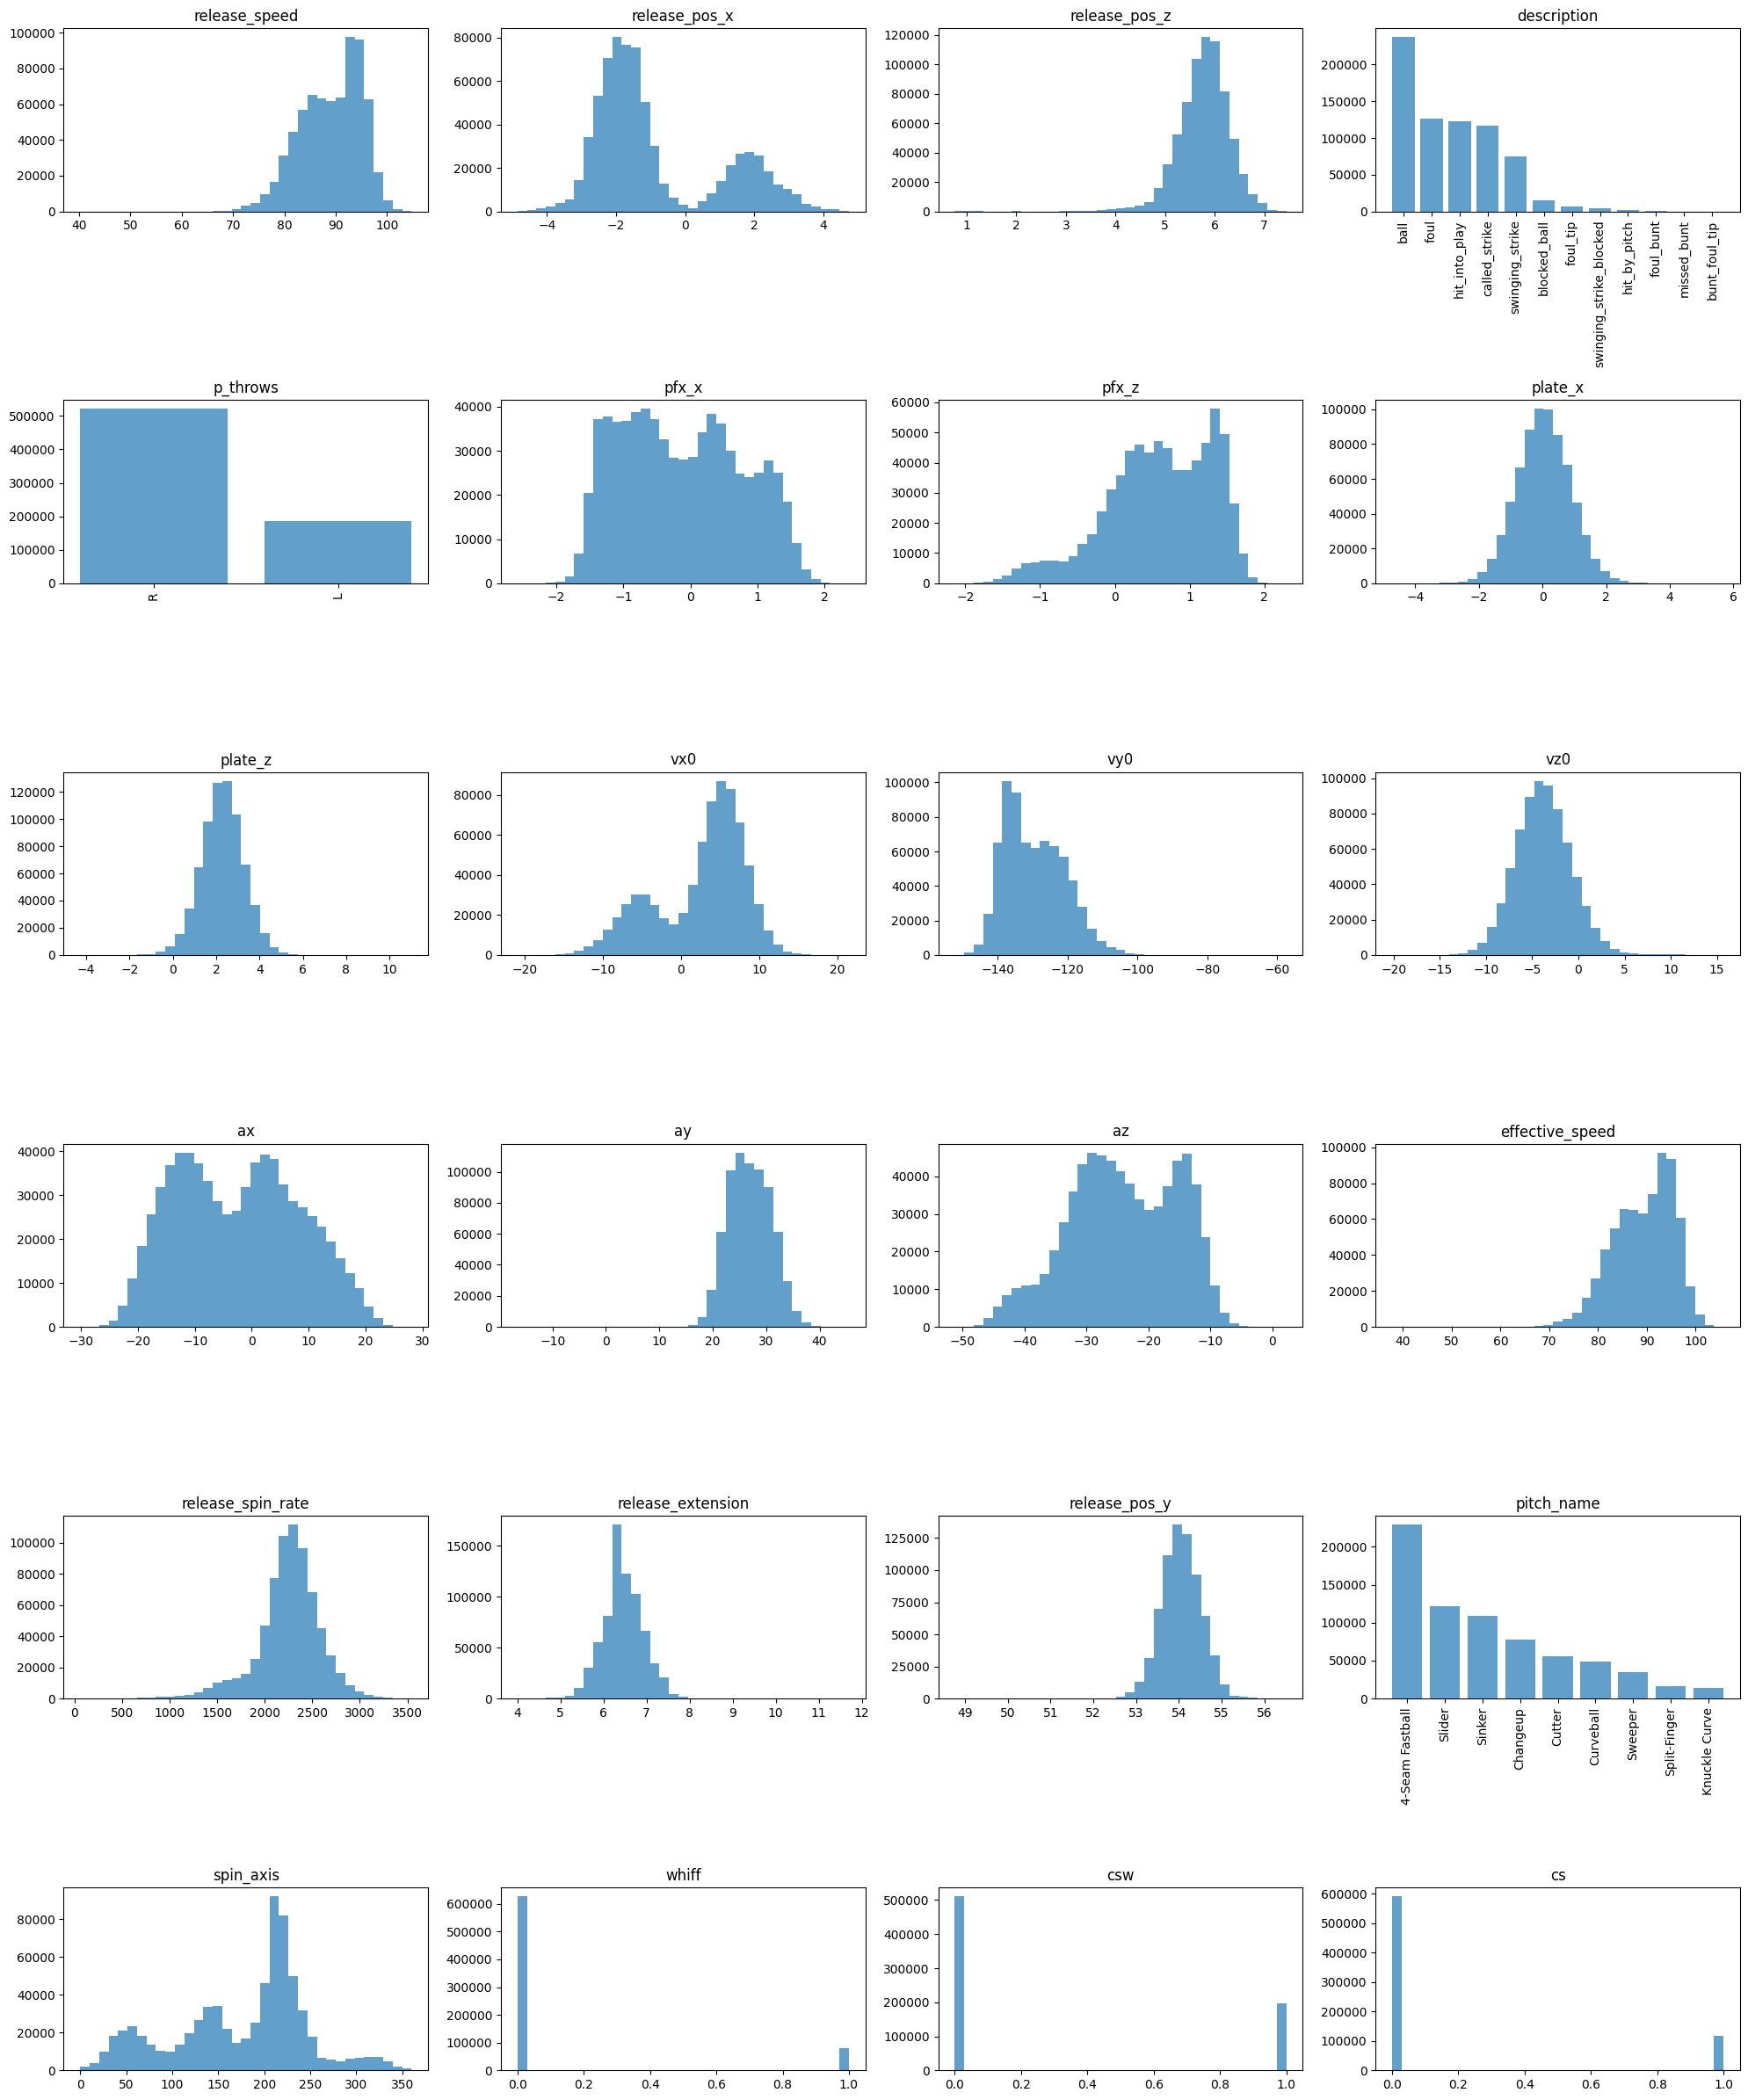

In [196]:
num_columns = len(mlb.columns)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 24))
axes = axes.flatten()

for ax, column in zip(axes, mlb.columns):
    if pd.api.types.is_numeric_dtype(mlb[column]):
        ax.hist(mlb[column], bins=35, alpha=0.7)
    else:
        counts = mlb[column].value_counts()
        ax.bar(counts.index, counts.values, alpha=0.7)
        ax.set_xticks(range(len(counts.index)))
        ax.set_xticklabels(counts.index, rotation=90)
    ax.set_title(f'{column}')

plt.tight_layout()
plt.savefig('STA_160_baseball_dist.png', dpi=300, bbox_inches='tight')
plt.show()

#### All pitches Covariance Matrix

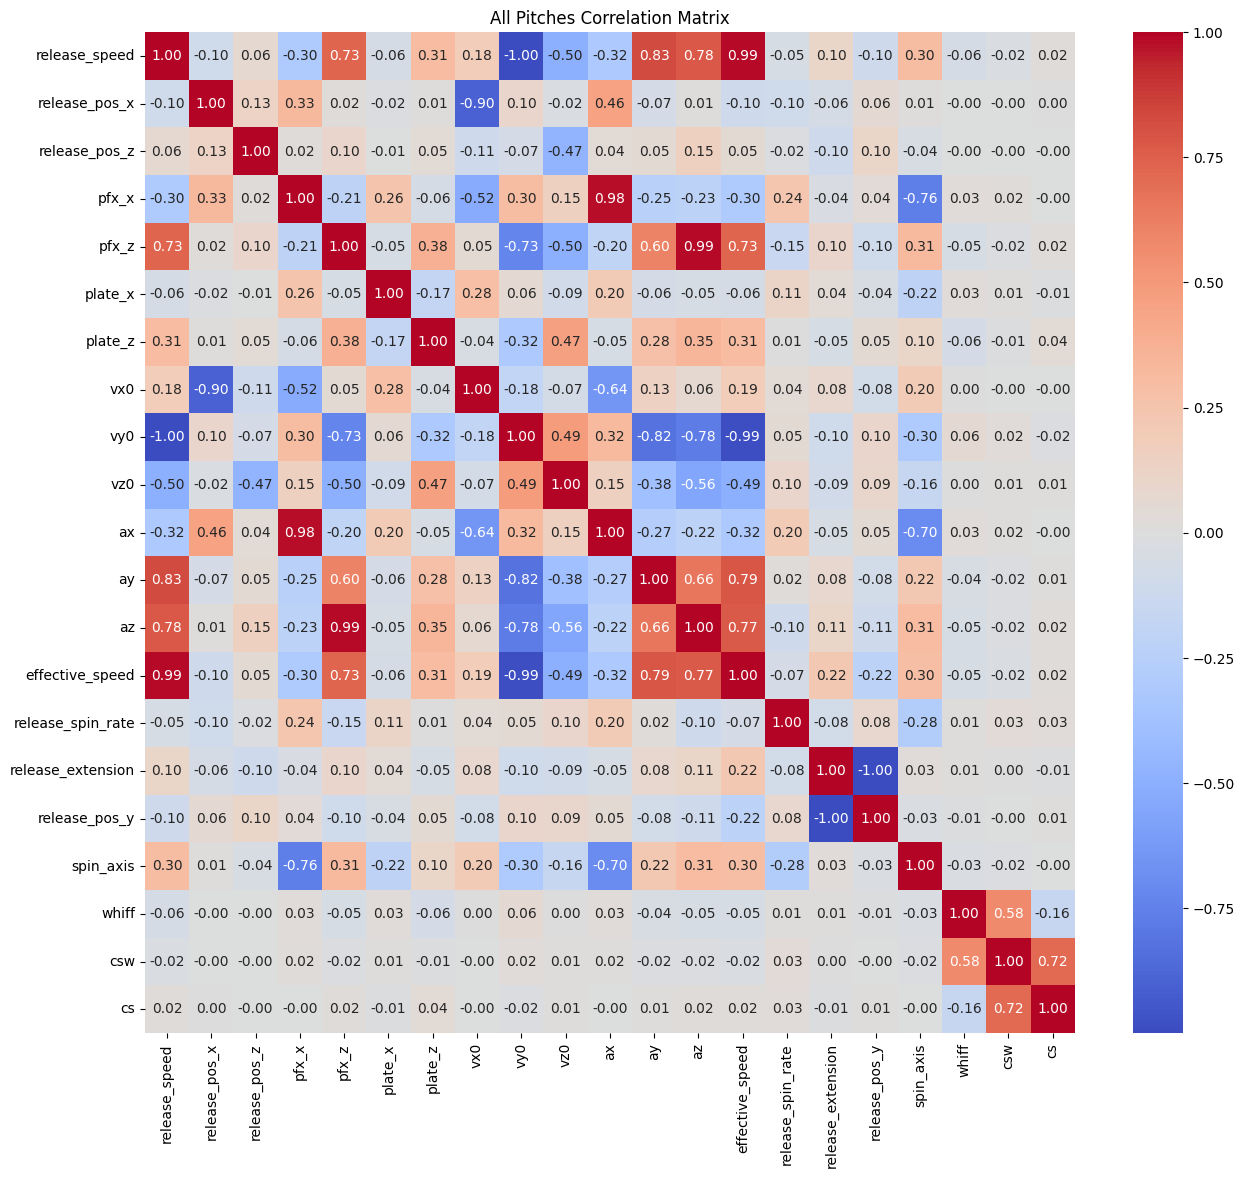

In [200]:
cor_matrix = mlb_numeric.corr()

plt.figure(figsize=(15, 13))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('All Pitches Correlation Matrix')
plt.savefig('STA_160_corr_matrix_1.png', dpi=300, bbox_inches='tight')
plt.show()

#### Interaction DF & Covariance Matrix

In [201]:
mlb_int = mlb.copy()
mlb_int['plate_z_vz0'] = mlb_int['plate_z']*mlb_int['vz0']
mlb_int['plate_z_az'] = mlb_int['plate_z']*mlb_int['az']
mlb_int['plate_z_release_speed'] = -mlb_int['plate_z']*mlb_int['release_speed']
mlb_int['plate_z_vy0'] = mlb_int['plate_z']*mlb_int['vy0']
mlb_int['plate_z_effective_speed'] = mlb_int['plate_z']*mlb_int['effective_speed']

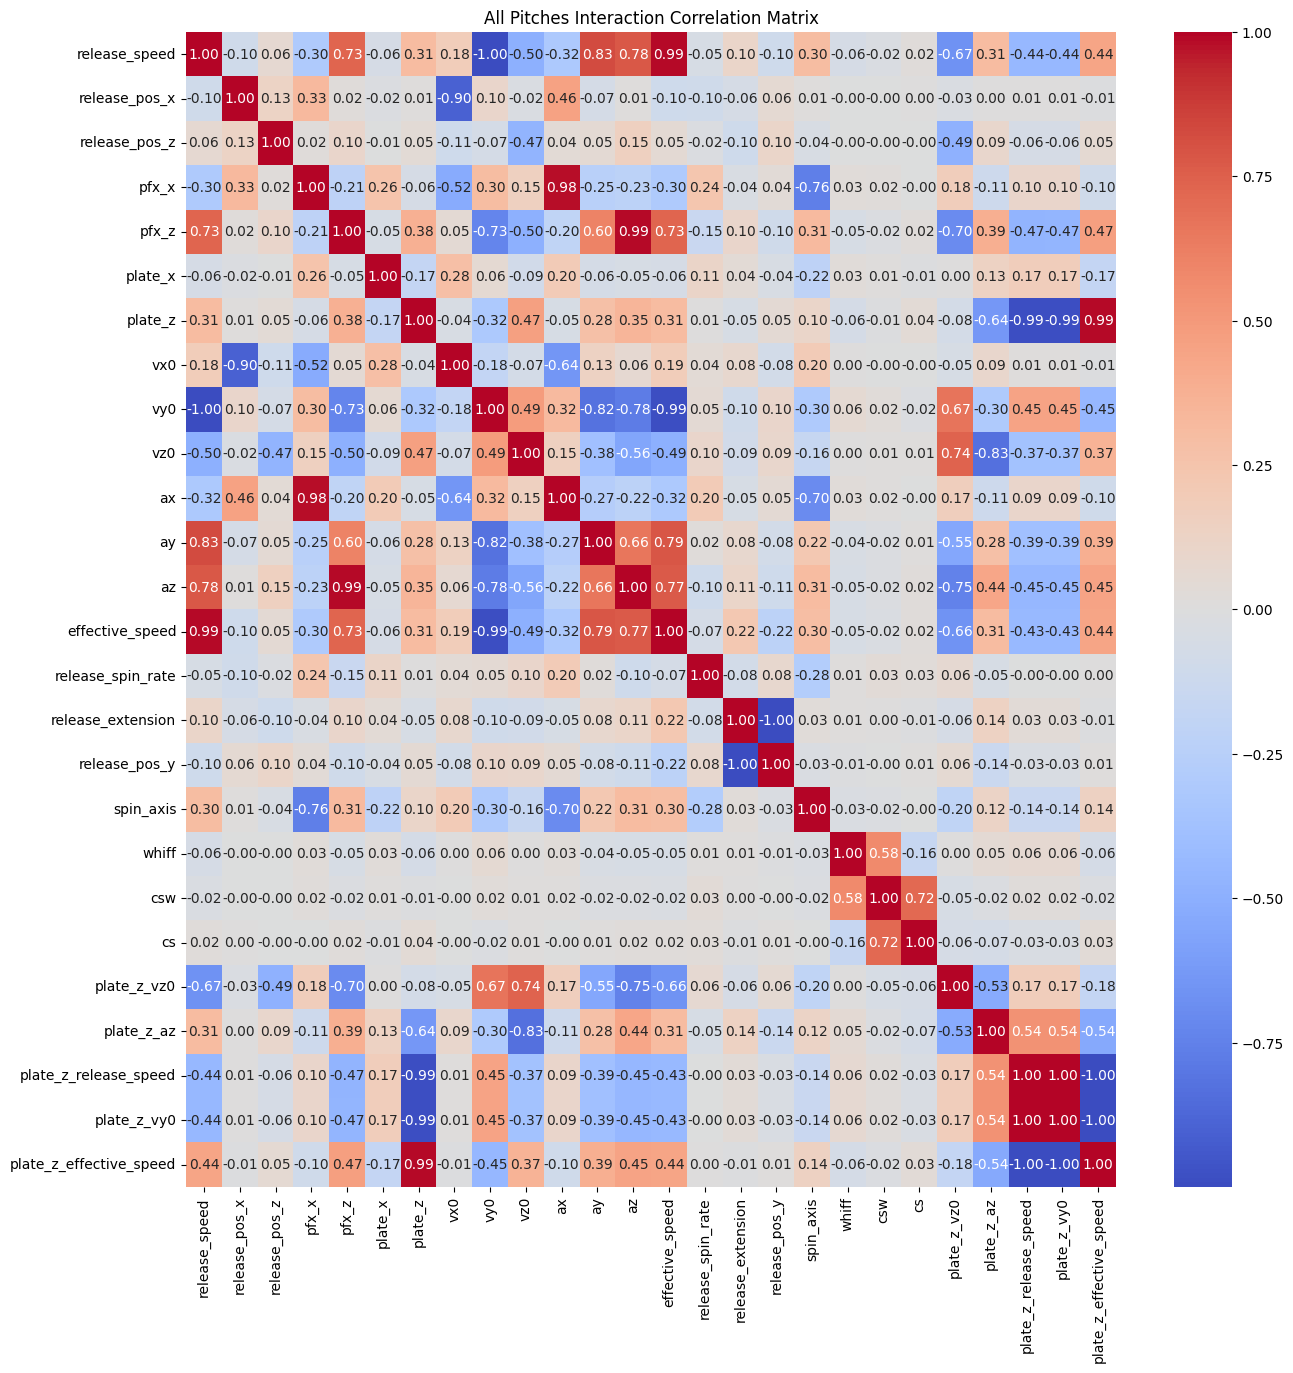

In [203]:
mlb_int_numeric = mlb_int.drop(columns=['description', 'pitch_name', 'p_throws'])
cor_matrix = mlb_int_numeric.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('All Pitches Interaction Correlation Matrix')
plt.savefig('STA_160_corr_matrix_2.png', dpi=300, bbox_inches='tight')
plt.show()

#### Individual Pitch Covariance Matrices

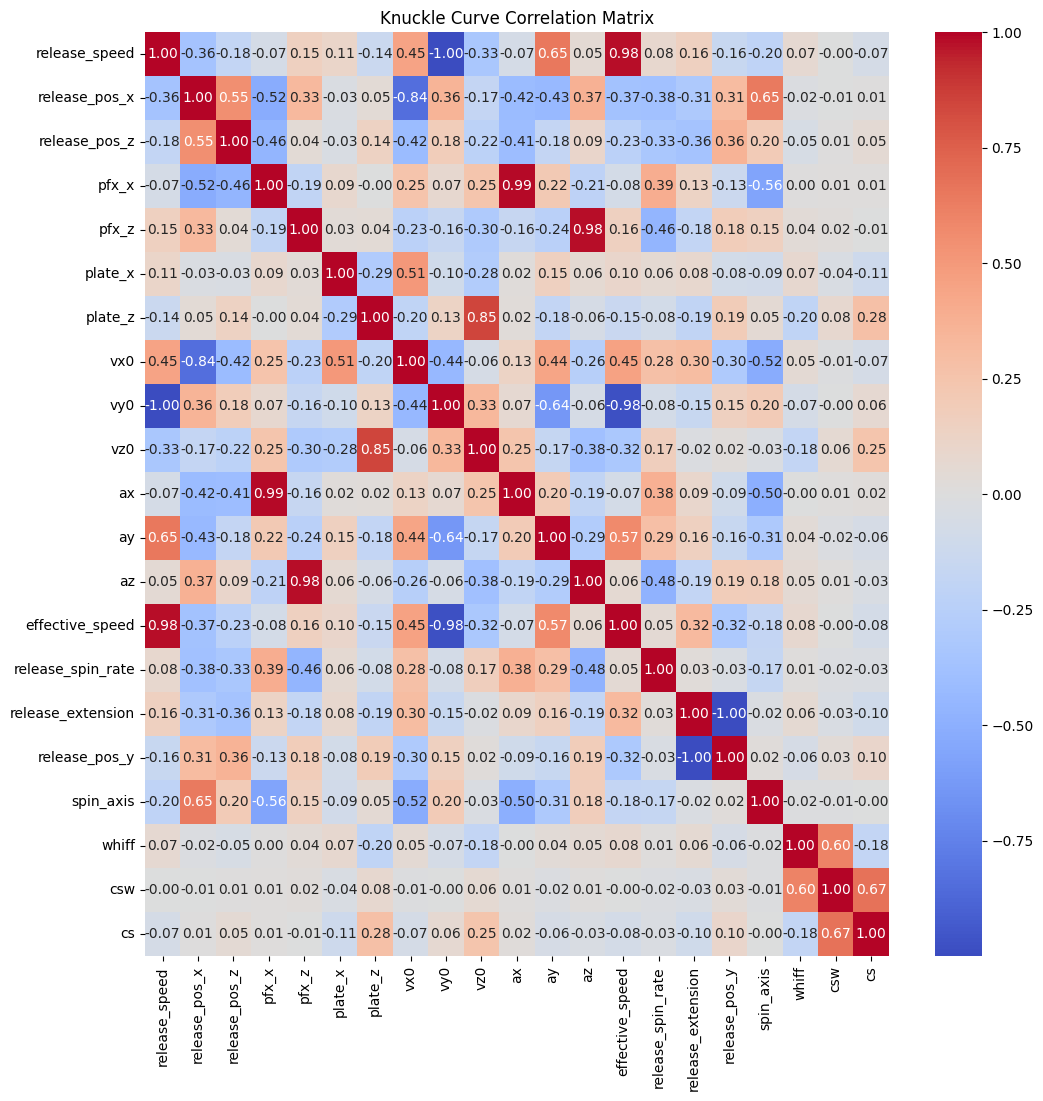

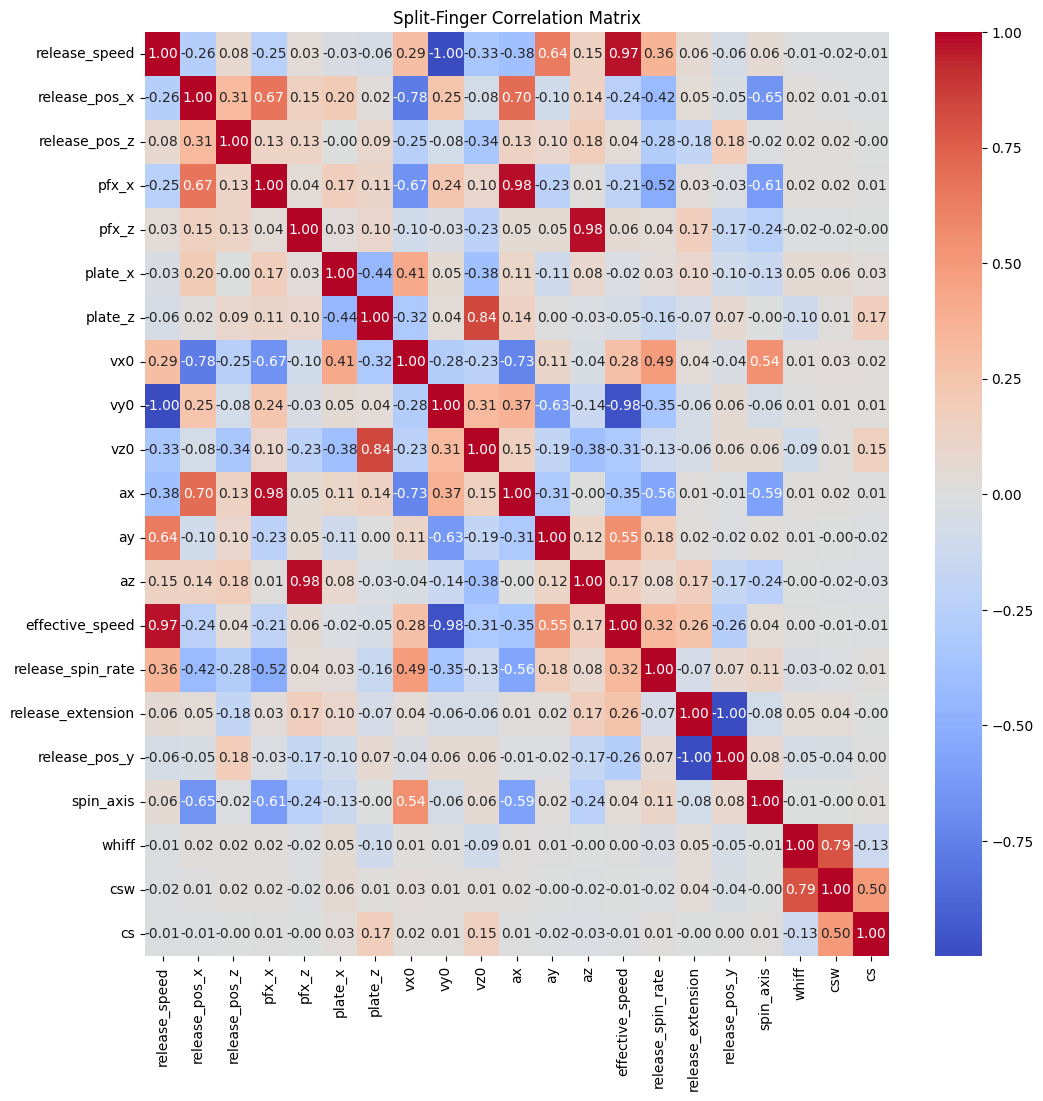

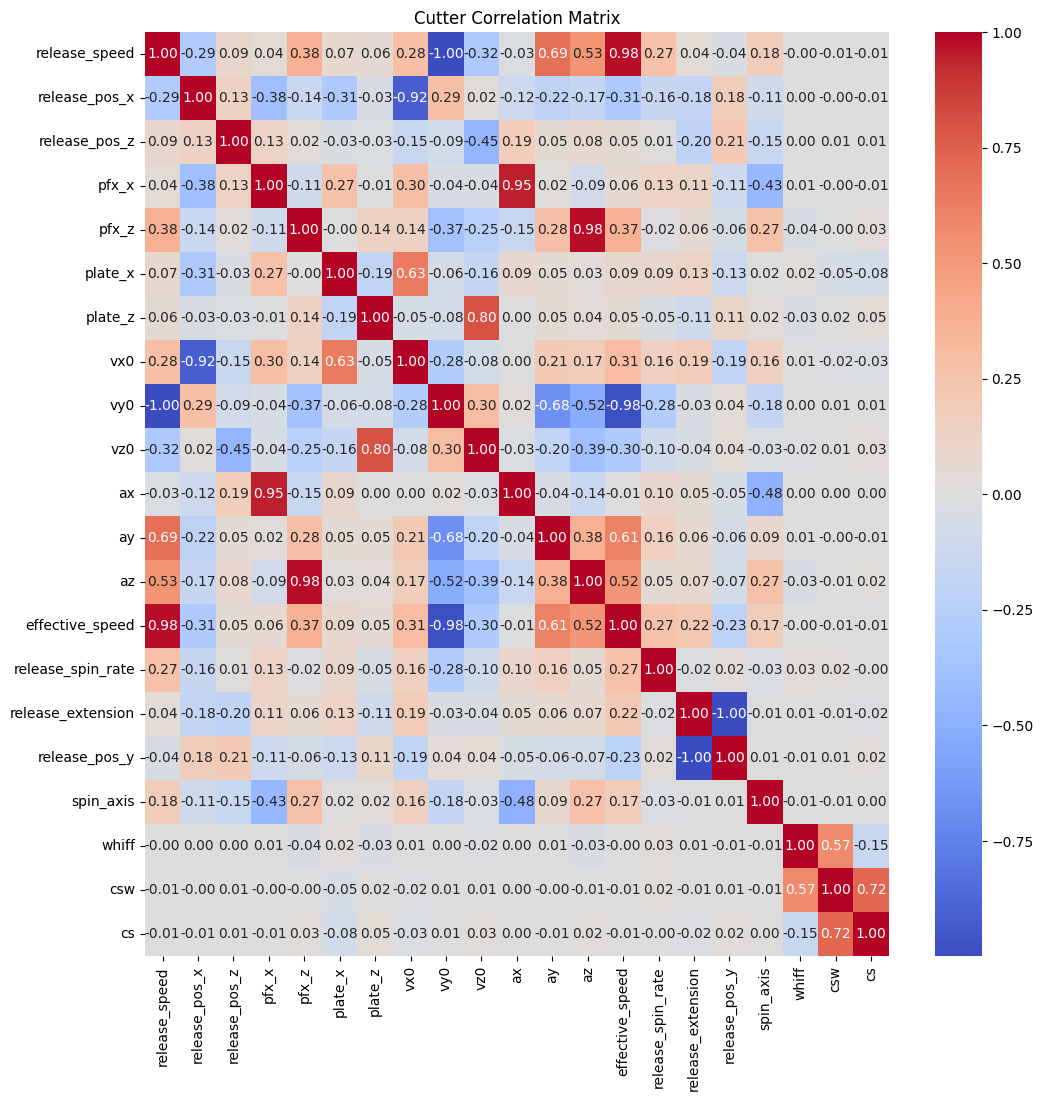

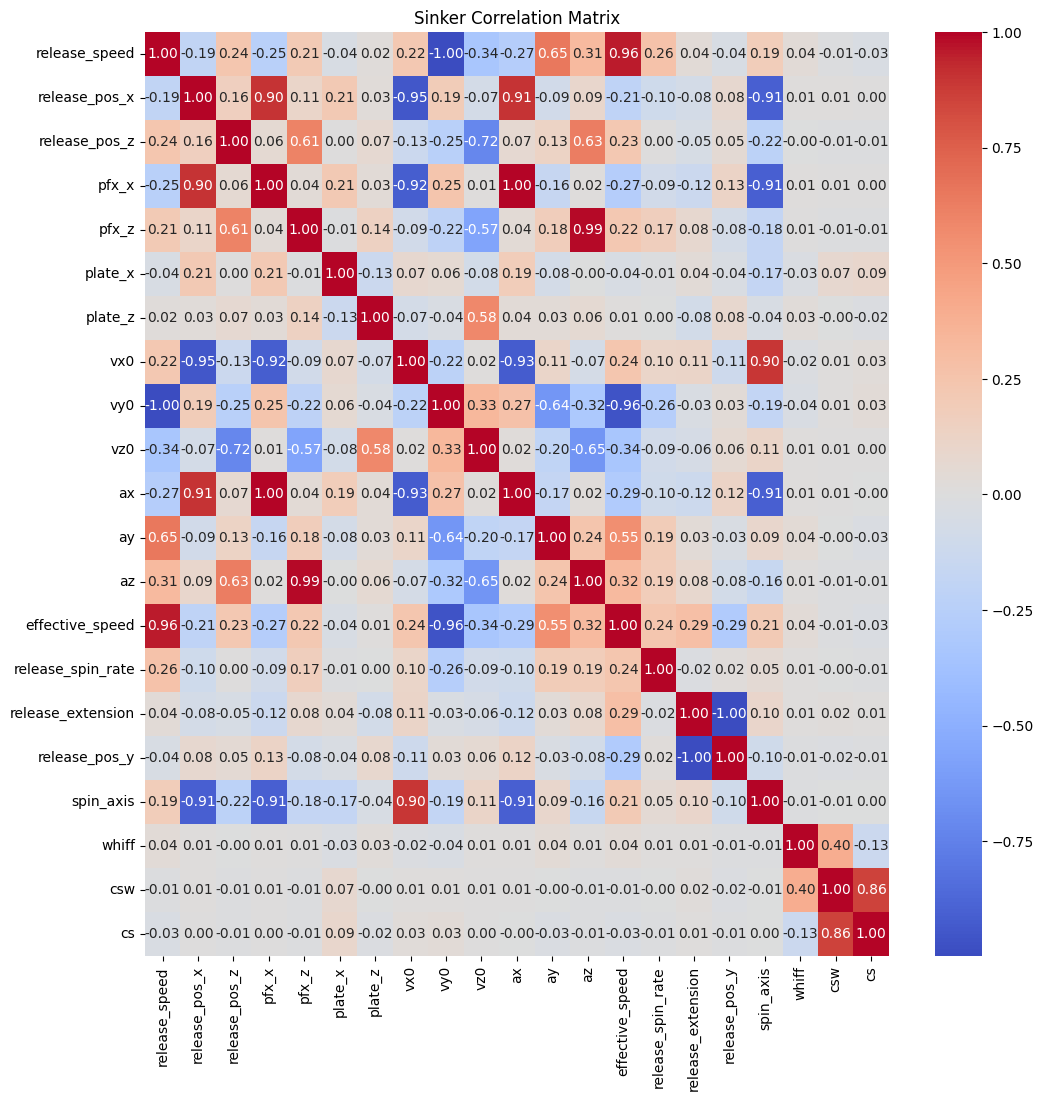

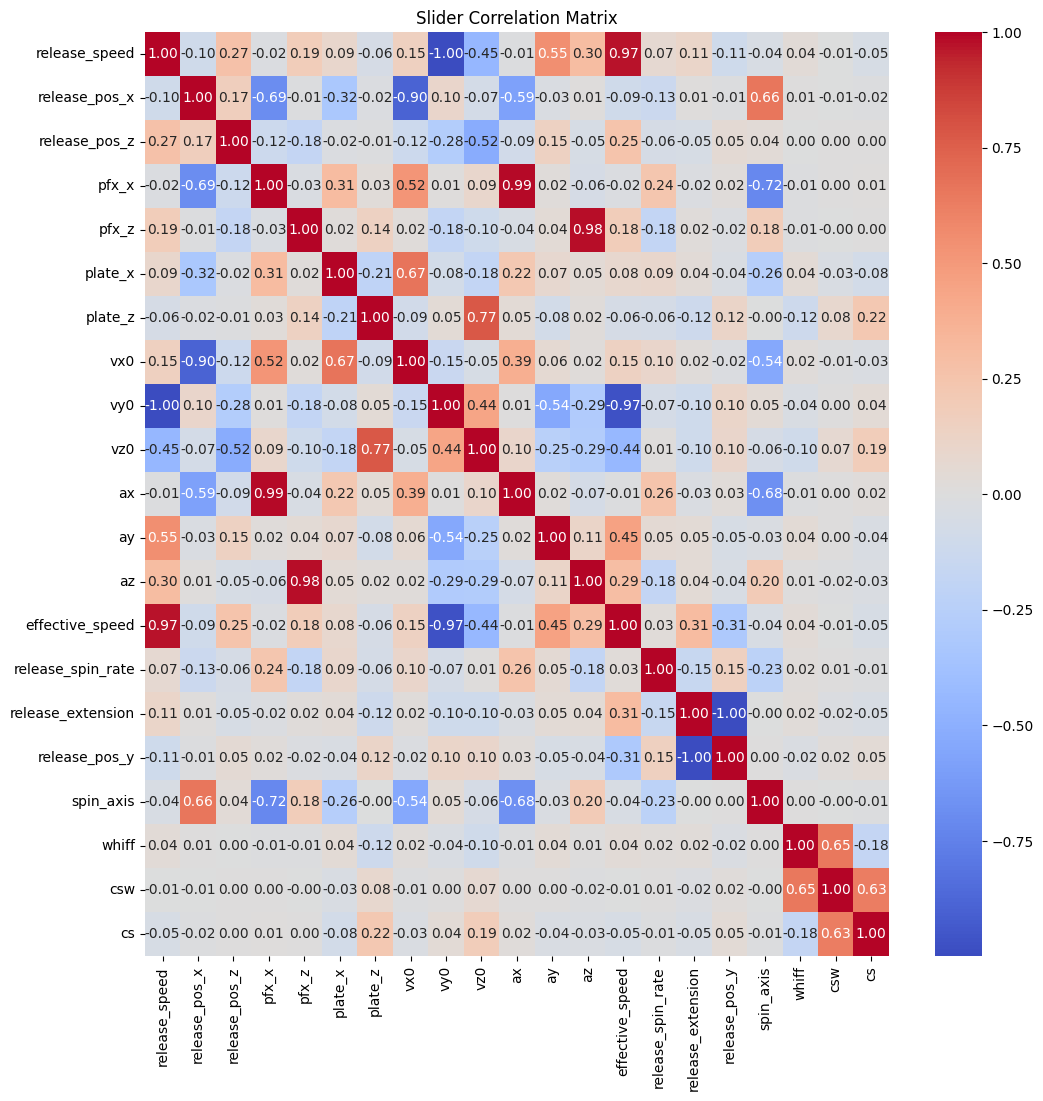

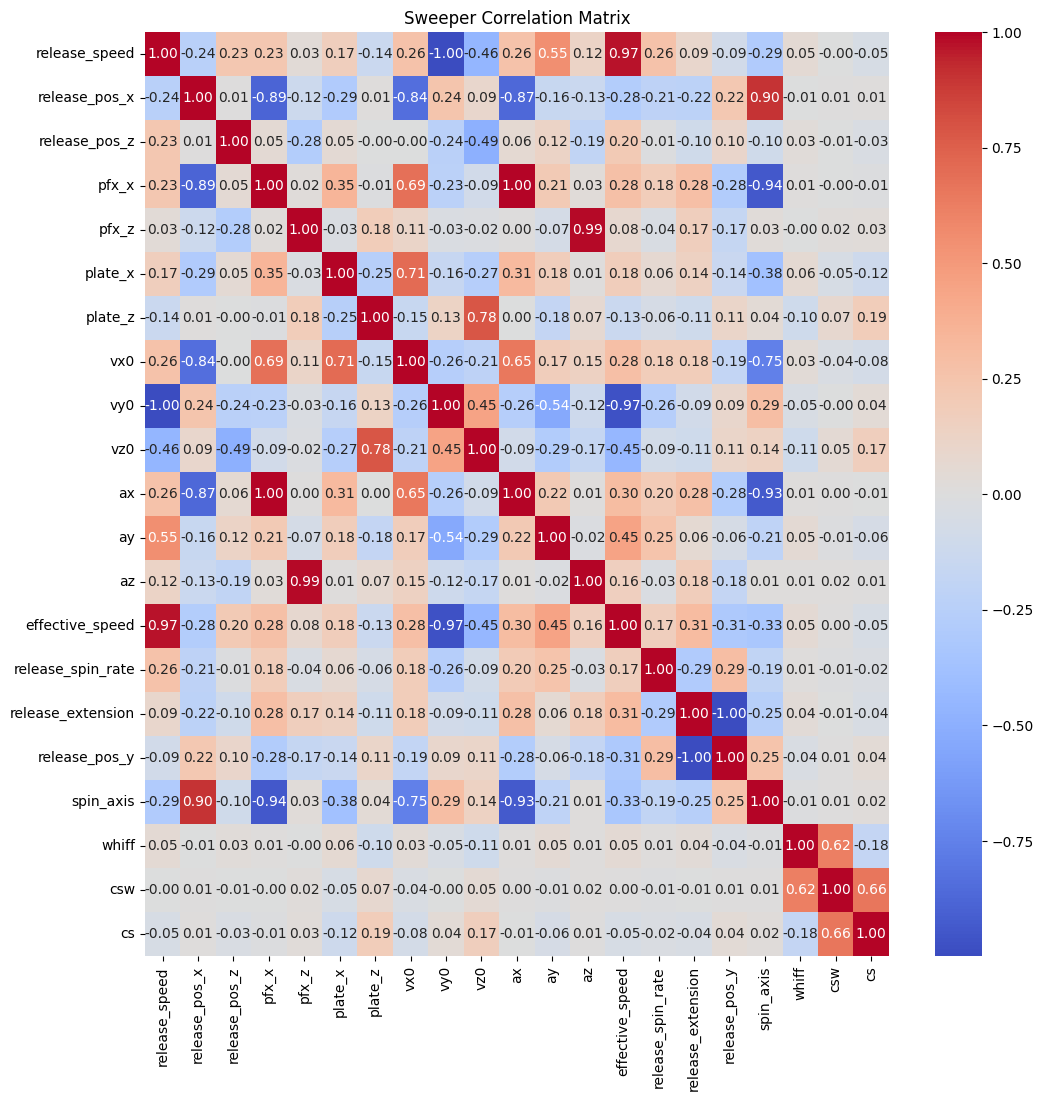

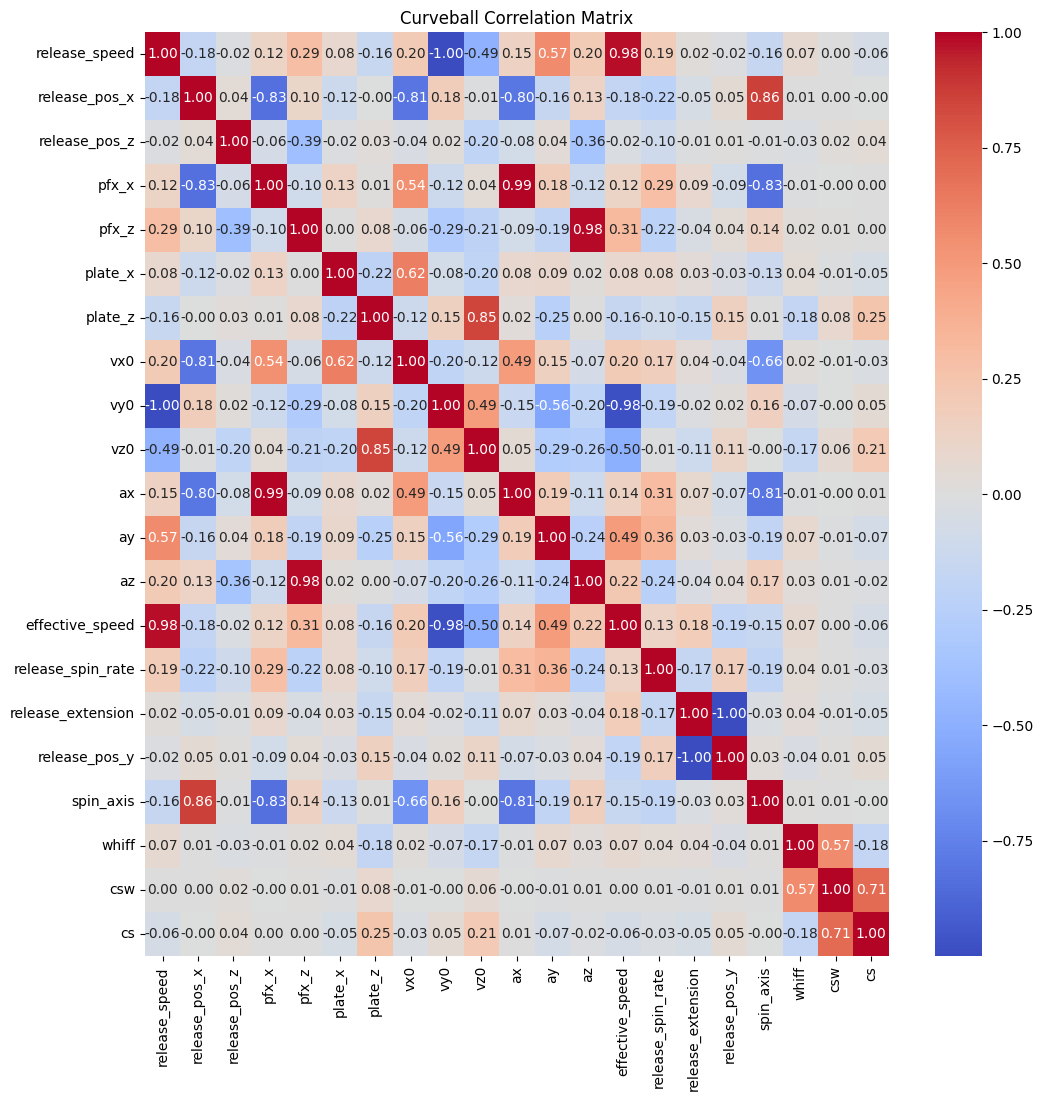

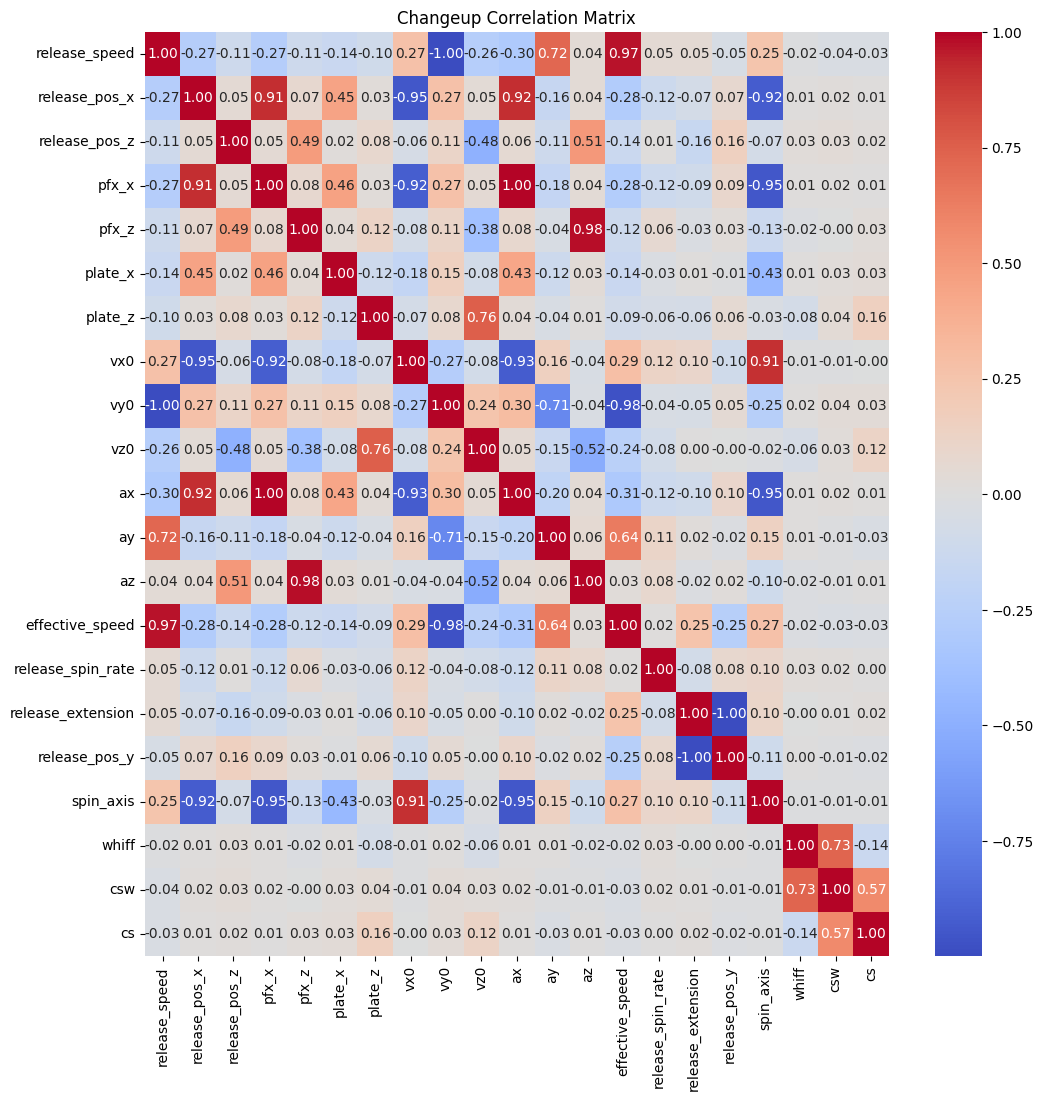

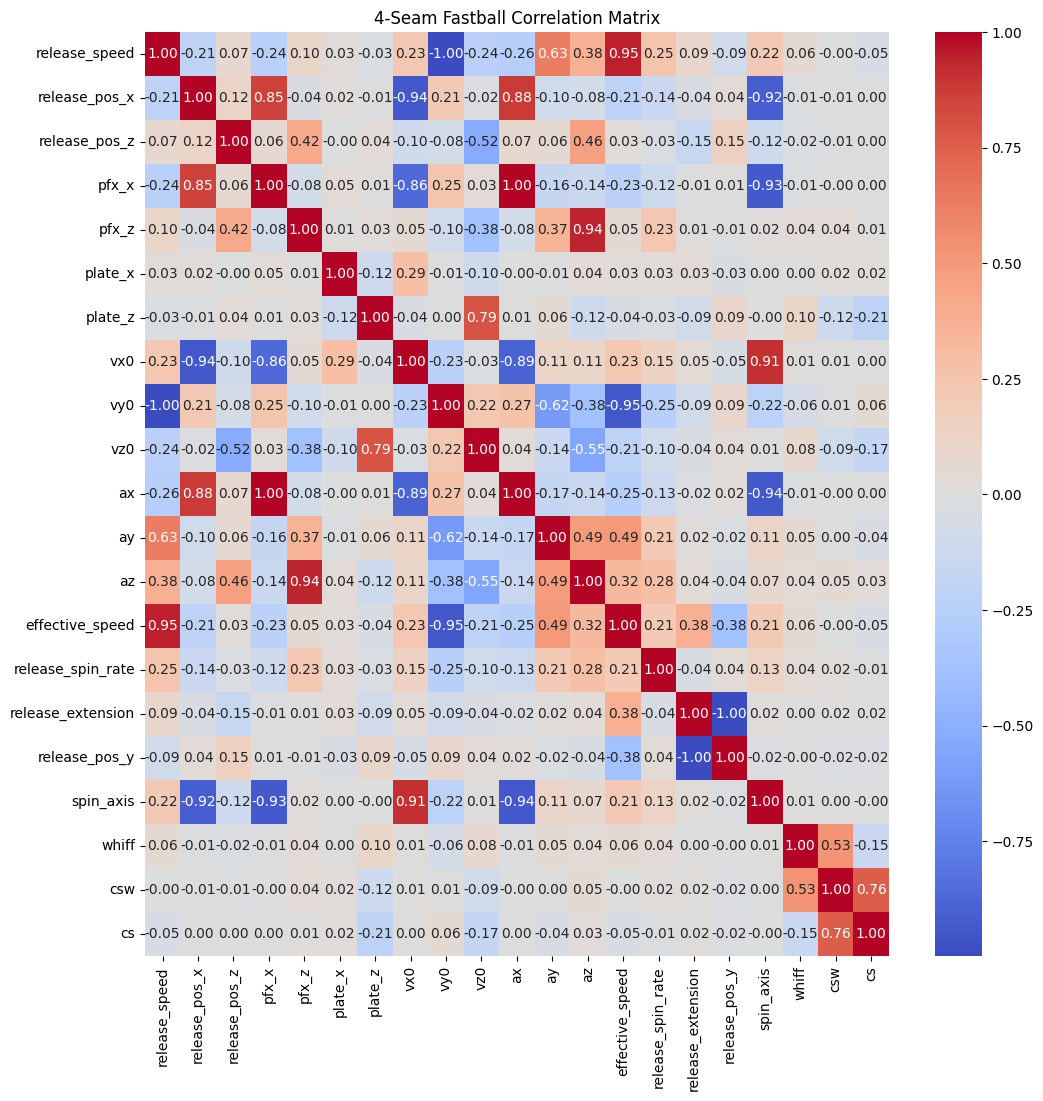

In [204]:
for pitch in set(mlb['pitch_name']):
    mlb_per_pitch = mlb[mlb['pitch_name'] == pitch]
    mlb_pp_numeric = mlb_per_pitch.drop(columns=['description', 'pitch_name', 'p_throws'])
    cor_matrix = mlb_pp_numeric.corr()

    plt.figure(figsize=(12, 12))
    sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'{pitch} Correlation Matrix')
    if pitch == 'Curveball':
        plt.savefig('STA_160_corr_matrix_3.png', dpi=300, bbox_inches='tight')
    plt.show()

#### Visualizing CS and Whiff (Separately) Behavior

In [84]:
mlb.head(n=8).T

2373             2453        2574        2681  \
release_speed               89.0             96.9        90.0        82.2   
release_pos_x               -2.8             -2.4       -2.93       -3.09   
release_pos_z               5.59              5.9        5.56        5.55   
description        hit_into_play             foul        ball        ball   
p_throws                       R                R           R           R   
pfx_x                      -1.53            -0.76       -1.65        1.43   
pfx_z                       0.33             1.36        0.36        0.28   
plate_x                     0.33             0.09       -0.24        0.81   
plate_z                     2.01             2.71        0.53        0.49   
vx0                    11.122985         8.558215   10.328033    6.108013   
vy0                  -129.176025      -140.741874 -130.515462 -119.483805   
vz0                     -3.49208        -6.148396   -7.371558   -5.435467   
ax                    -19.471845       -12.116762  -20.978432   12.155221   
ay                     26.055263        34.259201   27.339657   26.646301   
az                    -27.922064       -12.836434  -26.599717  -28.491928   
effective_speed             90.7             98.4        91.5        82.4   
release_spin_rate           1703             2153        1698        2786   
release_extension            7.4              7.4         7.4         6.9   
release_pos_y              53.11            53.13       53.14       53.63   
pitch_name              Changeup  4-Seam Fastball    Changeup     Sweeper   
spin_axis                    250              211         250          58   
whiff                          0                0           0           0   
csw                            0                0           0           0   
cs                             0                0           0           0   

                              2810             2902             2989  \
release_speed                 89.2             96.2             88.2   
release_pos_x                -2.87            -2.37            -2.86   
release_pos_z                 5.58             5.96             5.51   
description        swinging_strike  swinging_strike  swinging_strike   
p_throws                         R                R                R   
pfx_x                        -1.49            -0.71            -1.45   
pfx_z                         0.31              1.4             0.43   
plate_x                      -0.78             0.59            -0.82   
plate_z                       2.05             3.56             1.19   
vx0                       8.417443         9.626067         8.123411   
vy0                    -129.604641      -139.750857      -128.123445   
vz0                       -3.33637        -3.982147        -5.373029   
ax                      -18.554455       -11.630817       -17.605529   
ay                       27.650862        33.893158        26.545899   
az                      -28.148796       -13.112827       -26.498222   
effective_speed               90.5             97.4             89.6   
release_spin_rate             1589             2213             1656   
release_extension              7.2              7.3              7.2   
release_pos_y                53.29            53.24            53.26   
pitch_name                Changeup  4-Seam Fastball         Changeup   
spin_axis                      257              215              254   
whiff                            1                1                1   
csw                              1                1                1   
cs                               0                0                0   

                              3128  
release_speed                 95.7  
release_pos_x                 -2.4  
release_pos_z                  5.8  
description                   foul  
p_throws                         R  
pfx_x                        -0.48  
pfx_z                          1.3  
plate

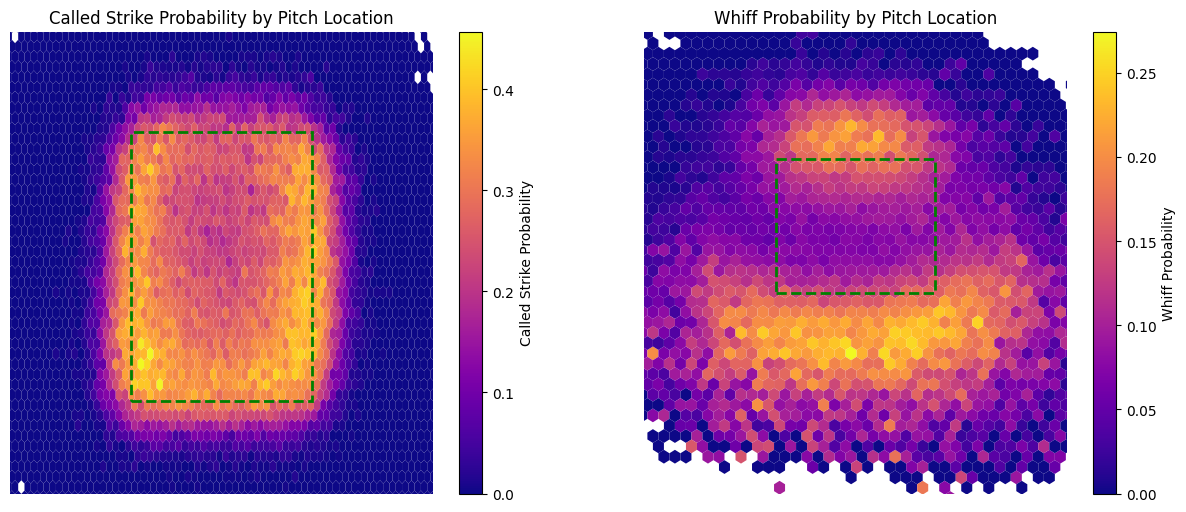

In [205]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

hb1 = ax1.hexbin(mlb['plate_x'], mlb['plate_z'], C=mlb['cs'], gridsize=200, cmap='plasma', edgecolors=None, mincnt=10)
ax1.axis('off')
ax1.set_xlim(-1.75, 1.75)
ax1.set_ylim(1, 4)
ax1.set_xlabel('plate_x')
ax1.set_ylabel('plate_y')
ax1.set_title('Called Strike Probability by Pitch Location')
cb1 = fig.colorbar(hb1, ax=ax1, label='Called Strike Probability')

hb2 = ax2.hexbin(mlb['plate_x'], mlb['plate_z'], C=mlb['whiff'], gridsize=100, cmap='plasma', edgecolors=None, mincnt=10)
ax2.axis('off')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-1, 5)
ax2.set_xlabel('plate_x')
ax2.set_ylabel('plate_y')
ax2.set_title('Whiff Probability by Pitch Location')
cb2 = fig.colorbar(hb2, ax=ax2, label='Whiff Probability')

strike_zone_coords = (-0.75, 1.6)  # Bottom-left corner of the strike zone
strike_zone_width = 1.5  # Width of the strike zone
strike_zone_height = 1.75  # Height of the strike zone

# Draw strike zone box for ax1
strike_zone_ax1 = Rectangle(strike_zone_coords, strike_zone_width, strike_zone_height, linestyle='--', linewidth=2, edgecolor='green', facecolor='none')
ax1.add_patch(strike_zone_ax1)

# Draw strike zone box for ax2
strike_zone_ax2 = Rectangle(strike_zone_coords, strike_zone_width, strike_zone_height, linestyle='--', linewidth=2, edgecolor='green', facecolor='none')
ax2.add_patch(strike_zone_ax2)

plt.savefig('STA_160_location.png', dpi=300, bbox_inches='tight')
plt.show()

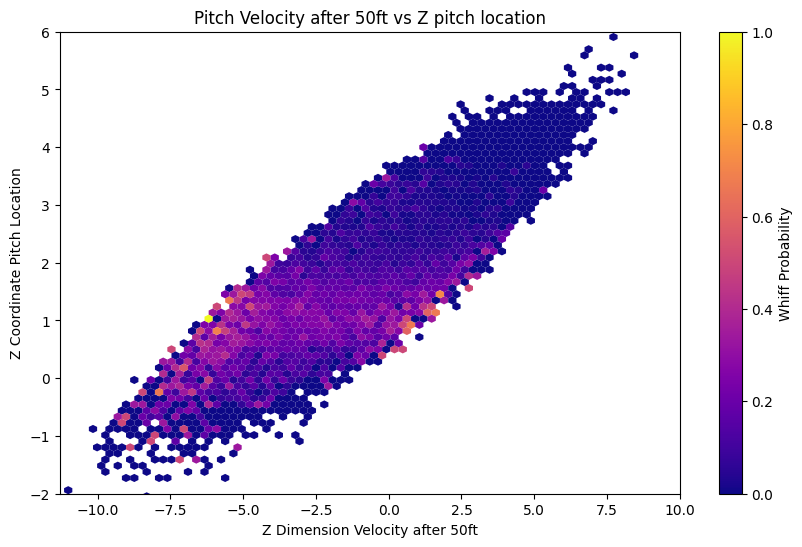

In [206]:
mlb_curve = mlb[mlb['pitch_name'] == 'Curveball']

plt.figure(figsize=(10, 6))
hb = plt.hexbin(mlb_curve['vz0'], mlb_curve['plate_z'], C=mlb_curve['whiff'], gridsize=100, cmap='plasma', edgecolors=None, mincnt=2)
plt.colorbar(hb, label='Whiff Probability')
plt.xlabel('Z Dimension Velocity after 50ft')
plt.ylabel('Z Coordinate Pitch Location')
plt.title('Pitch Velocity after 50ft vs Z pitch location')

plt.xlim(-11.3, 10)
plt.ylim(-2, 6)

plt.savefig('STA_160_velo_location.png', dpi=300, bbox_inches='tight')
plt.show()

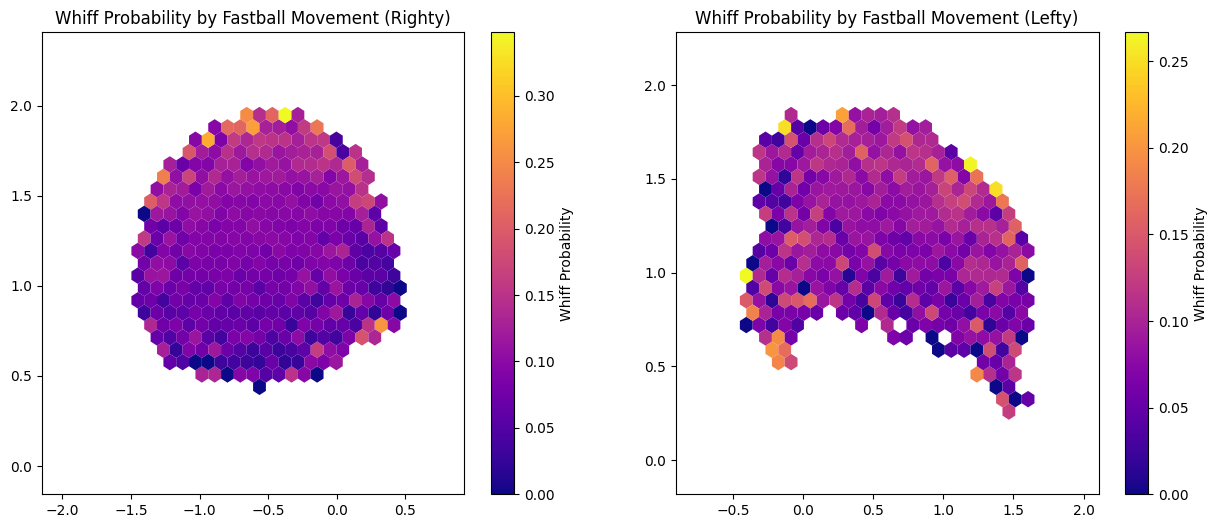

In [211]:
mlb_ff_r = mlb_r[mlb_r['pitch_name'] == '4-Seam Fastball']
mlb_ff_l = mlb_l[mlb_l['pitch_name'] == '4-Seam Fastball']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

hb1 = ax1.hexbin(mlb_ff_r['pfx_x'], mlb_ff_r['pfx_z'], C=mlb_ff_r['whiff'], gridsize=30, cmap='plasma', edgecolors=None, mincnt=15)
# ax1.set_xlim(-1.5, 0.5)
# ax1.set_ylim(0.5, 2)
ax1.set_title('Whiff Probability by Fastball Movement (Righty)')
cb1 = fig.colorbar(hb1, ax=ax1, label='Whiff Probability')

hb2 = ax2.hexbin(mlb_ff_l['pfx_x'], mlb_ff_l['pfx_z'], C=mlb_ff_l['whiff'], gridsize=30, cmap='plasma', edgecolors=None, mincnt=15)
# ax2.set_xlim(-0.5, 1.8)
# ax2.set_ylim(0.5, 1.8)
ax2.set_title('Whiff Probability by Fastball Movement (Lefty)')
cb2 = fig.colorbar(hb2, ax=ax2, label='Whiff Probability')

plt.savefig('STA_160_whiff_prob_ff.png', dpi=300, bbox_inches='tight')
plt.show()

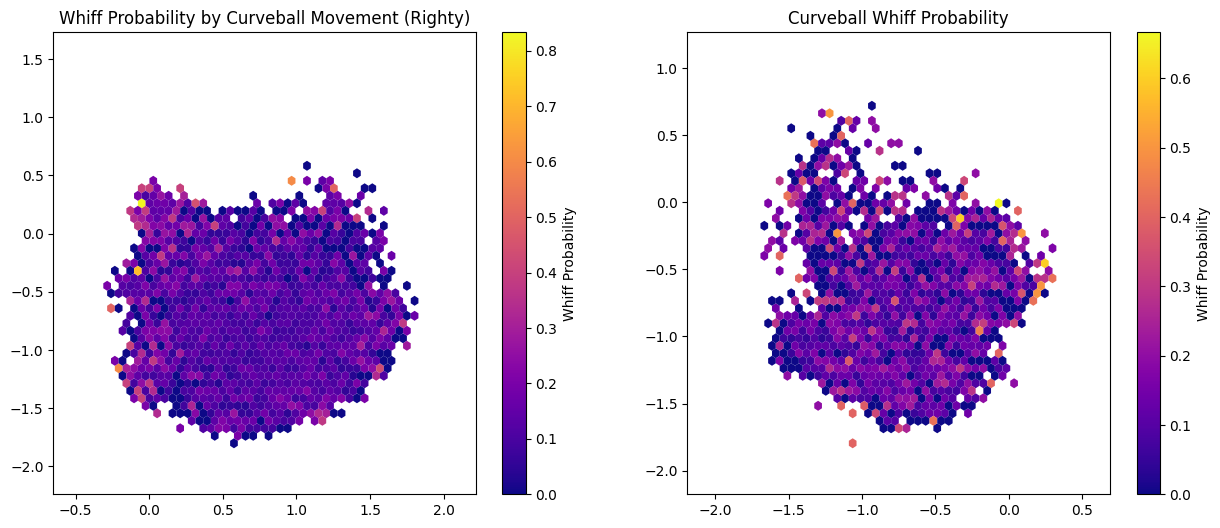

In [166]:
mlb_curve_r = mlb_r[mlb_r['pitch_name'] == 'Curveball']
mlb_curve_l = mlb_l[mlb_l['pitch_name'] == 'Curveball']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

hb1 = ax1.hexbin(mlb_curve_r['pfx_x'], mlb_curve_r['pfx_z'], C=mlb_curve_r['whiff'], gridsize=50, cmap='plasma', edgecolors=None, mincnt=5)
# ax1.set_xlim(-1.75, 1.75)
# ax1.set_ylim(1, 4)
ax1.set_title('Whiff Probability by Curveball Movement (Righty)')
cb1 = fig.colorbar(hb1, ax=ax1, label='Whiff Probability')

hb2 = ax2.hexbin(mlb_curve_l['pfx_x'], mlb_curve_l['pfx_z'], C=mlb_curve_l['whiff'], gridsize=50, cmap='plasma', edgecolors=None, mincnt=5)
# ax2.set_xlim(-2, 2)
# ax2.set_ylim(-1, 5)
ax2.set_title('Whiff Probability by Curveball Movement (Lefty)')
cb2 = fig.colorbar(hb2, ax=ax2, label='Whiff Probability')

plt.title('Curveball Whiff Probability')
plt.show()

### Model Fitting

In [169]:
# hehe